In [74]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [75]:
# Need to make further changes to that save path, so it's more iterative.
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/model_training_output/keypoint_classifier4c.hdf5'
tflite_save_path = 'model/keypoint_classifier/model_training_output/keypoint_classifier4c.tflite'

# Set number of classes

In [76]:
NUM_CLASSES = 6

# Dataset reading

In [77]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [78]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [80]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

Increased model complexity and added L2 regularization for better returns.

In [81]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 42)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                2752      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 6)                 198       
                                                                 
Total params: 5,030
Trainable params: 5,030
Non-trainable params: 0
_________________________________________________________________


In [82]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [83]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [84]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
50/53 [===========================>..] - ETA: 0s - loss: 2.2585 - accuracy: 0.4366
Epoch 1: saving model to model/keypoint_classifier/model_training_output\keypoint_classifier4c.hdf5
53/53 [==============================] - 1s 12ms/step - loss: 2.2406 - accuracy: 0.4424 - val_loss: 1.8003 - val_accuracy: 0.6276
Epoch 2/1000
49/53 [==========================>...] - ETA: 0s - loss: 1.7356 - accuracy: 0.5928
Epoch 2: saving model to model/keypoint_classifier/model_training_output\keypoint_classifier4c.hdf5
53/53 [==============================] - 0s 8ms/step - loss: 1.7252 - accuracy: 0.5951 - val_loss: 1.4613 - val_accuracy: 0.6862
Epoch 3/1000
46/53 [=========================>....] - ETA: 0s - loss: 1.4707 - accuracy: 0.6364
Epoch 3: saving model to model/keypoint_classifier/model_training_output\keypoint_classifier4c.hdf5
53/53 [==============================] - 0s 7ms/step - loss: 1.4652 - accuracy: 0.6378 - val_loss: 1.2234 - val_accuracy: 0.7520
Epoch 4/1000
46/53 [====

In [85]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

18/18 [==============================] - 0s 7ms/step - loss: 0.4188 - accuracy: 0.9364


In [86]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [87]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 39ms/step
[2.7493727e-05 3.4892598e-06 3.1532764e-01 3.6440830e-04 3.1847823e-02
 6.5242916e-01]
5


# Confusion matrix

71/71 [==============================] - 0s 3ms/step


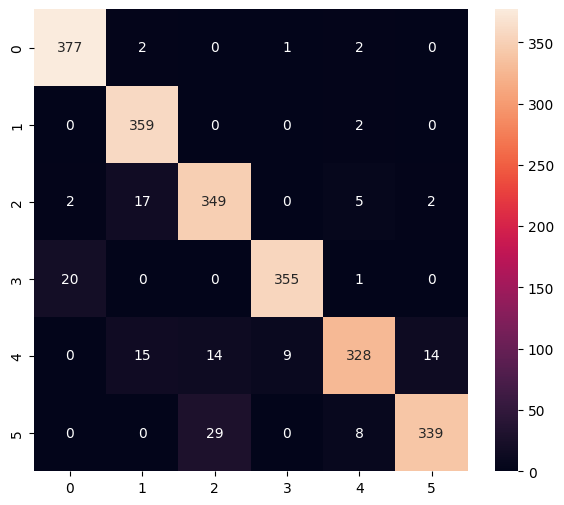

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       382
           1       0.91      0.99      0.95       361
           2       0.89      0.93      0.91       375
           3       0.97      0.94      0.96       376
           4       0.95      0.86      0.90       380
           5       0.95      0.90      0.93       376

    accuracy                           0.94      2250
   macro avg       0.94      0.94      0.94      2250
weighted avg       0.94      0.94      0.94      2250



In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [89]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [90]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\remko\AppData\Local\Temp\tmpyycxql0i\assets


INFO:tensorflow:Assets written to: C:\Users\remko\AppData\Local\Temp\tmpyycxql0i\assets


8128

# Inference test

In [91]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [92]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [93]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [96]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [97]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.5978670e-05 3.4217771e-06 3.1091565e-01 3.3306348e-04 3.1835292e-02
 6.5688664e-01]
5
